# **Colab 用户注意**

# **不要直接在此文件写内容——你的进度可能会丢失！**

# **开始前务必先“保存副本”。**

如何保存副本

1. 点击左上角的“File”。
> *如果找不到菜单栏（如“File”或“Runtime”），点右上角的“v”号展开菜单。*

2. 选择“Save a copy in Drive”。

3. 把复制的文件名改成“YOURNAMEs_FileName.ipynb”。
> 例如：如果你叫 Olivia，就改成 Olivias_FileName.ipynb。



---

* 勾选（✅）不会保存。如果用 Chrome 的刷新按钮重载页面，勾选状态会消失。<br>
想暂停后再继续，直接新建文本单元，写上“SO FAR DONE”之类的字就行。

---

* 在 Colab 里，**之前的输出会每隔 30 到 90 分钟清空**。<br>
  因此你经常会遇到 `~~ is not defined` 这类错误。

  🔁 遇到 `~~ is not defined` 错误怎么办？
  1. 先确认变量拼写没错。<br>
  2. 拼写没错的话，**点一下想重启的那个单元格**。<br>
  3. 点击左上角“Runtime” → 选“Run before”。<br>
     → 这会**重新运行之前所有单元**。
  4. 然后再运行本单元。

  如果还报错，说明你之前某个 TODO 的答案可能有根本错误。<br>
  赶紧检查你的答案是否正确。<br>
  或者问问 ChatGPT 或其他编程助手帮忙。

# **Chapter 3: PositionEmbedding**

### **Section 0: Preparation**

本节仅加载前面章节的内容。<br>
直接运行代码即可——不必仔细阅读。<br>
你也可以直接跳过。<br>

In [ ]:
# 下载文件
!wget https://raw.githubusercontent.com/HayatoHongo/Everyones_nanoGPT/main/input.txt -O input.txt
# 加载刚刚下载的名为 input.text 的文件，编码为 utf-8。
with open("input.txt", 'r', encoding = 'utf-8') as f:
    text = f.read()

# 一个用于美观显示张量的函数（可以跳过）
import torch
import torch.nn as nn

def print_formatted_tensor(*args, width=6, decimals=2):
    """
    A function that neatly formats and displays a PyTorch Tensor, and also prints its size.

    Example usage:
        print_formatted_tensor("name", tensor)
        print_formatted_tensor(tensor)

    Args:
        *args: If given 1 argument, it is treated as a tensor.
               If given 2 arguments, the first is treated as the name, the second as the tensor.
        width (int): Display width for each number (default: 6)
        decimals (int): Number of decimal places to show (default: 2)
    """

    # Determine tensor and name from arguments
    if not args:
        raise ValueError("At least one argument is required.")
    if isinstance(args[0], str):
        if len(args) < 2:
            raise ValueError("Tensor is not specified.")
        name, tensor = args[0], args[1]
    else:
        name, tensor = None, args[0]

    # Convert Tensor to List
    tensor_list = tensor.detach().cpu().tolist()

    def format_list(lst, indent):
        """Formatting a recursively nested list and returning a string"""
        # If the contents are lists, then re-return
        if isinstance(lst, list) and lst and isinstance(lst[0], list):
            inner = ",\n".join(" " * indent + format_list(sub, indent + 2) for sub in lst)
            return "[\n" + inner + "\n" + " " * (indent - 2) + "]"
        # For numerical lists
        return "[" + ", ".join(f"{v:{width}.{decimals}f}" for v in lst) + "]"

    # Formatted string (bar brackets on outermost frames are removed)
    formatted = format_list(tensor_list, indent=9)
    inner_formatted = formatted[1:-1].strip()

    # Result output
    if name:
        print(name)
    print(f"Tensor Size: {list(tensor.size())}")
    print("tensor([")
    print(" " * 9 + inner_formatted)
    print(" " * 7 + "])")

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # 定义一个嵌入表，用于词汇量为 x，嵌入维度为 number 的词向量生成
        self.token_embedding_table = nn.Embedding(vocab_size, embedding_dim)

    def embed(self, input_indices):
        # 获取对应输入索引的嵌入向量
        return self.token_embedding_table.forward(input_indices)

### **Section 1: __init__**

**什么是 Positional Embedding？**  
通常，Token Embedding 会给每个字母或单词分配一个固定的向量。  
但这样一来，同样的字母（比如 "L"）无论出现在哪里，向量都一样。  
这就忽略了位置信息。  

可是，**单词或字母的位置** 对理解上下文至关重要。  
这时就用到了 **Positional Embedding**。  

Positional Embedding 是用向量来表示**序列数据中位置（比如字符串中的位置）**的方法。  
比如，句子中的第1个字母、第2个字母、第3个字母，每个都会有独特的向量。  

将这些位置向量加到 Token Embedding 上，模型就能**知道每个词在什么位置**。  
这帮助模型更好地处理上下文，理解语言更自然。  
  
---

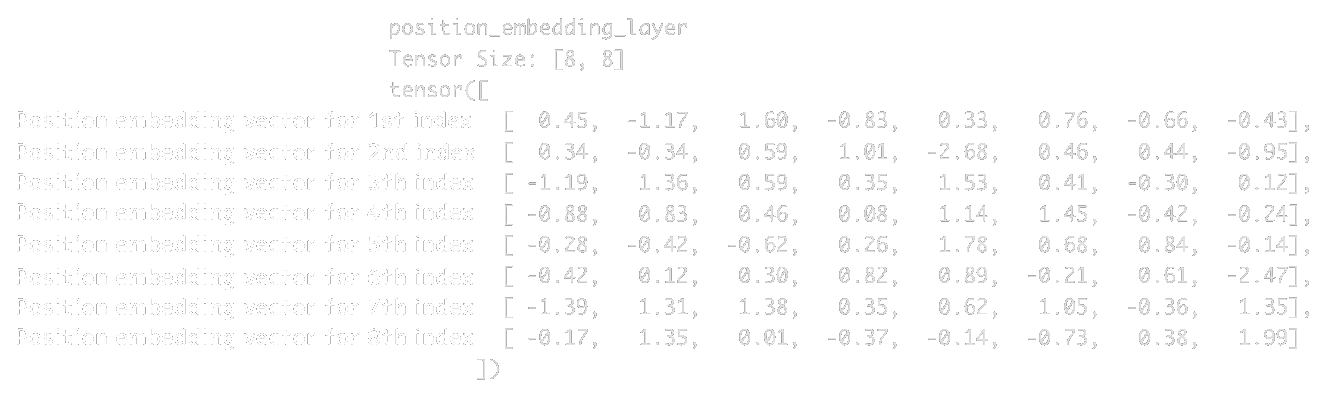

**Learnable Positional Embedding**  
Learnable positional embedding 为每个位置分配一个**可训练向量**，就像词元嵌入一样。<br>
它最初是随机值。<br>
这种方法被应用于 BERT、GPT、ViT 等模型。<br>
它的优点是能适应数据。<br>
现在已经广泛替代了传统的正弦位置编码。<br>
注意不要和更有名的正弦位置编码混淆。<br>

| Positional Embedding | 特点                       | 应用模型                    |
|----------------------|----------------------------|-----------------------------|
| **Sinusoidal PE**    | 由公式固定，不可训练         | Transformer 原始论文 (Vaswani et al., 2017) |
| **Learnable PE**     | 使用 `nn.Embedding`，可训练  | BERT，GPT，ViT              |
| **Relative PE**      | 考虑相对位置                 | ALiBi，T5 等                |

创建一个 Embedding 层

```python
Class: nn.Embedding
Arguments:
  - num_embeddings: 嵌入字典的大小 (=8)
  - embedding_dim: 每个嵌入向量的维度 (=8)
```
- `nn.Embedding(8, 8)` 创建一个层，将 8 个元素（位置）转成 8 维的嵌入向量。
- 这个层用 8 维特征向量表示位置信息，<br>跟 `TokenEmbedding` 的嵌入维度保持一致。

In [ ]:
torch.manual_seed(1337)
token_embedding_layer = nn.Embedding(65, 8)

# 创建嵌入层
position_embedding_layer = # TODO: nn.Embedding(嵌入字典大小, 嵌入向量维度)
print_formatted_tensor("位置嵌入层", position_embedding_layer.weight)

**Section 1: init** <label><input type="checkbox"> 标记为完成</label>

### **Section 2: Forward**

获取特定位置的embedding向量

```python
Instance: position_embedding_layer
Method: forward or optional
Argument: torch.tensor([2])
```
- 从embedding层`position_embedding_layer`中获取索引为`2`（第3个字符）的位置的embedding向量。

In [ ]:
# 获取指定位置（索引2）的嵌入向量
position_embedding_for_third_position = # TODO: 实例.方法(参数)
print_formatted_tensor(position_embedding_for_third_position)

创建位置索引列表

```python
Function: torch.arange
Argument: 8
```
- `torch.arange(8)` 创建一个包含从0到7连续整数的张量。


In [ ]:
position_indices = # TODO: 创建一个包含从0到7的整数的张量
print_formatted_tensor(position_indices)

获取位置索引的嵌入向量

```python
Instance: position_embedding_layer
Method: forward or optional
Argument: position_indices
```
- 获取给定 `position_indices` 对应的一系列嵌入向量。


In [ ]:
position_embeddings = # TODO: 实例.方法(参数)
print_formatted_tensor("位置嵌入", position_embeddings)

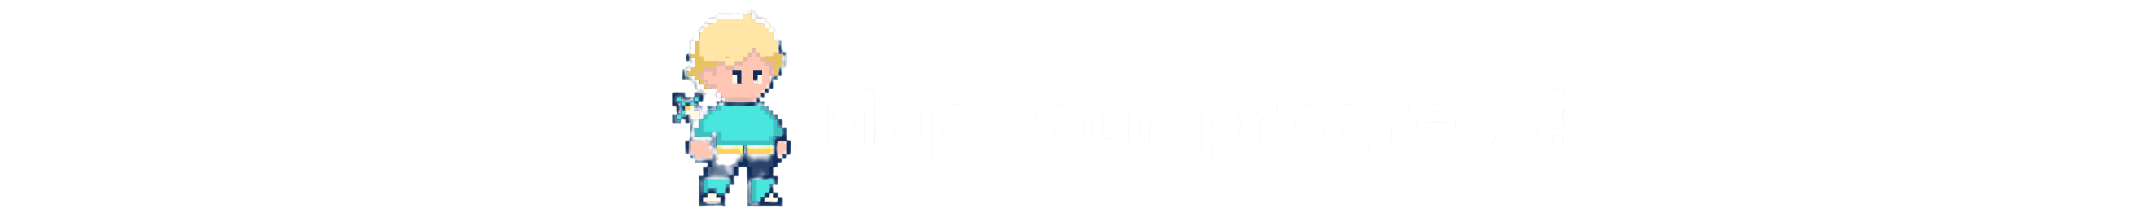

由于它只处理位置，上述嵌入字典可用于任何8字符的字符串。<br>
（内部的数字会在训练中变化。）

**Section 2: forward** <label><input type="checkbox"> 标记为完成</label>

### **Section 3: Define a class**

🔘 **Options**：可能会有一些你用不到的额外选项。

`Embedding`  `arange`  `1`  `0`  `position_embedding_layer.forward`  `zeros`


In [ ]:
class PositionEmbedding(nn.Module):
    def __init__(self, input_sequence_length = 8, embedding_dim = 8):
        super().__init__()
        # 位置嵌入层
        self.position_embedding_layer = nn._____(input_sequence_length, embedding_dim)

    def forward(self, input_indices):
        # 输入张量 input_indices 的形状：[批量大小，序列长度]。
        sequence_length = input_indices.shape[_____]

        # 根据序列长度创建位置索引（例如 [0, 1, 2, ..., sequence_length-1]）
        position_indices = torch._____(sequence_length, device=input_indices.device)

        # 获取位置索引的嵌入向量
        position_embeddings = self._____(position_indices)

        return position_embeddings

<details>
<summary>点击这里显示/隐藏答案</summary>

```python
class PositionEmbedding(nn.Module):
    def __init__(self, input_sequence_length = 8, embedding_dim = 8):
        super().__init__()
        # 位置嵌入层
        self.position_embedding_layer = nn.Embedding(input_sequence_length, embedding_dim)

    def forward(self, input_indices):
        # 输入张量 input_indices 的形状：[批大小，序列长度]。
        sequence_length = input_indices.shape[1]

        # 根据序列长度创建位置索引（例如 [0, 1, 2, ..., sequence_length-1]）
        position_indices = torch.arange(sequence_length, device=input_indices.device)

        # 获取对应位置索引的嵌入向量
        position_embeddings = self.position_embedding_layer.forward(position_indices)

        return position_embeddings
```

**Module Operation Check**

In [ ]:
# 存储模型设置的配置类
class ModelConfig:
    batch_size = 1  # 每次处理的数据量（批量大小）
    input_sequence_length = 8  # 输入数据长度（序列长度）
    embedding_dim = 8  # 嵌入层大小（特征向量的维度数）

```python
类：PositionEmbedding
参数：input_sequence_length = （使用配置），embedding_dim = （使用配置）

实例 = 类(参数)
```

In [ ]:
# 检查模块的运行情况
torch.manual_seed(1337)

config = ModelConfig()
token_embedding_layer = TokenEmbedding(vocab_size = 65, embedding_dim = config.embedding_dim)

position_embedding_layer = PositionEmbedding(input_sequence_length=config.input_sequence_length, embedding_dim=config.embedding_dim) # TODO: 创建一个位置嵌入层的实例

```python
Instance: position_embedding_layer
Method: forward (optional)
Argument: sample_input_tokens

position_embeddings = Instance.Method(argument)
```

In [ ]:
# 兼容 Let's he。(批量大小，令牌长度) = (1, 8)
sample_input_tokens = torch.tensor([[24, 43, 58, 5, 57, 1, 46, 43]])
position_embeddings = # TODO: 计算 sample_input_tokens 的位置编码
print_formatted_tensor("位置嵌入", position_embeddings)

位置嵌入是根据每个 token 在序列中的位置生成的，<br>
所以它们对每个 batch 都是一样的，没有 batch 维度。<br>

假设你把形状为 [8, 8] 的 `position embeddings` 加到形状为 [32, 8, 8] 的 `token embeddings` 张量上，<br>
不会报错。<br>
PyTorch 会自动把位置嵌入复制 32 份，加到每个 batch 里。<br>
这种自动扩展叫“广播（broadcasting）”。

在 PyTorch 中，很多操作带不带 batch 维度都能正常工作。<br>

**Section 3: Define a Class** <label><input type="checkbox"> 标记为完成</label>

**`Check Point`**  <label><input type="checkbox">  Chapter 3: PositionEmbedding Class  
</label>